In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1

In [12]:
def get_data(filename):
    fo = open(filename, 'r')
    datalines = fo.readlines()
    x0 = []
    x1 = []
    y = []
    for data in datalines:
        f0, f1, l = map(float, data.strip().split(' '))
        x0.append(f0)
        x1.append(f1)
        y.append(int(l))
    return x0, x1, y

In [152]:
def entropy(distribution):
    '''
    args
    distribution (np.ndarray)

    returns
    entropy (float)
    '''

    entropy = 0
    norm = sum(distribution)
    for val in distribution:
        if val == 0:
            entropy -= 0
        else:
            entropy -= (val/norm)*np.log2(val/norm)
    return entropy

def gain_ratio(labels, noneGain=False):
    '''
    args
    labels (np.ndarray(np.ndarray)) : Distribution of labels of feature (+1, -1) for each value of feature
    Eg. [9+, 5-] split at Humidity sets labels as [[3,4], [6,1]]

    returns
    gain_ratio (float):
    '''

    info_gain = 0
    node_distr = sum(labels)
    num = sum(node_distr)
    info_gain += entropy(node_distr)
    
    for p, n in labels:
        info_gain -= ((p+n)/num)*entropy([p,n])

    feat_distr = [sum(i) for i in labels]
    
    if entropy(feat_distr) == 0:
        if noneGain:
            return info_gain
        else:
            return None
    gain_ratio = info_gain/entropy(feat_distr)
    return gain_ratio

In [14]:
class node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = -1
        self.value = -1
        self.is_leaf = None

In [333]:
def build_tree(data, printLogs=False, forced=False):
    root = node()

    x0 = data[:,0]
    x1 = data[:,1]
    y = data[:,2]

    if printLogs:
        print('Feature candidate\tValue Candidate\t\tGain ratio (or IG)')

    max_gain = 0
    max_gain_data = []
    for feature_candidate in [0,1]:
        value_range = [set(x0), set(x1)][feature_candidate]
        for value_candidate in value_range:
            data_less = [0, 0]
            data_more = [0, 0]
            for d in data:
                if d[feature_candidate] < value_candidate:
                    data_less[int(d[2])] += 1
                else:
                    data_more[int(d[2])] += 1

            gr = gain_ratio(np.array([data_less, data_more]))
            if printLogs:
                if gr is None:
                    print(feature_candidate, '\t\t\t', value_candidate, '\t\t\t', gain_ratio(np.array([data_less, data_more]), True), '(IG)')
                else:
                    print(feature_candidate, '\t\t\t', value_candidate, '\t\t\t', gr)
            if gr is None:
                continue
            if gr > max_gain:
                max_gain = gr
                max_gain_data = [(feature_candidate, value_candidate)]
            elif gr == max_gain:
                max_gain_data.append((feature_candidate, value_candidate))

    if max_gain == 0:
        if forced:
            # forcing a split on feature 0 at the first datapoint
            root.feature = 0
            root.value = x0[0]
        else:
            root.is_leaf = 1 if np.sum(y) >= len(y)/2 else 0
            return root
            
    root.feature = max_gain_data[len(max_gain_data)//2][0]
    root.value = max_gain_data[len(max_gain_data)//2][1]

    plotter.append((root.feature, root.value))

    data_left = []
    data_right = []

    for d in data:
        if d[root.feature] >= root.value:
            data_left.append(d)
        else:
            data_right.append(d)

    root.left = build_tree(np.array(data_left))
    root.right = build_tree(np.array(data_right))

    return root

In [154]:
def printTree(root, level=0, branch='Root'):
    if root == None:
        return
    if root.is_leaf != None:
        print('\t'*level, f'{branch}: Leaf {root.is_leaf}')
        return
    print('\t'*level, f'{branch}: x{root.feature} >= {root.value}')
    printTree(root.left, level+1, 'L')
    printTree(root.right, level+1, 'R')

In [284]:
def plot_boundary(node, parent, prev_lims, lims):
    if not node or node.is_leaf is not None:
        return
    # print(node.feature, node.value, node.is_leaf)
    
    xmin, xmax, ymin, ymax = lims

    curr_lims = [ymin, ymax]

    if parent is None:
        if node.feature==0:
            plt.vlines(node.value, ymin, ymax)
            curr_lims = [ymin, ymax]
        elif node.feature==1:
            plt.hlines(node.value, xmin, xmax)
            curr_lims = [xmin, xmax]
    else:
        if node.feature==0:
            if parent.feature==1:
                if node==parent.left:
                    plt.vlines(node.value, parent.value, ymax)
                    curr_lims = [parent.value, ymax]
                elif node==parent.right:
                    plt.vlines(node.value, ymin, parent.value)
                    curr_lims = [ymin, parent.value]
            elif parent.feature==0:
                plt.vlines(node.value, prev_lims[0], prev_lims[1])
                curr_lims = prev_lims
        elif node.feature==1:
            if parent.feature==0:
                if node==parent.left:
                    plt.hlines(node.value, parent.value, xmax)
                    curr_lims = [parent.value, xmax]
                elif node==parent.right:
                    plt.hlines(node.value, xmin, parent.value)
                    curr_lims = [xmin, parent.value]
            elif parent.feature==1:
                plt.hlines(node.value, prev_lims[0], prev_lims[1])
                curr_lims = prev_lims

    plot_boundary(node.left, node, curr_lims, lims)
    plot_boundary(node.right, node, curr_lims, lims)

In [299]:
def plot_data(x0, x1, y, root=None, dataname=None):
    # plots all points of class 0 as O
    plt.scatter([x0[i] if not y[i] else None for i in range(len(y))], [x1[i] if not y[i] else None for i in range(len(y))], marker='o', s=60, color='orange', label='Class-0')

    # plots all points of class 1 as X
    plt.scatter([x0[i] if y[i] else None for i in range(len(y))], [x1[i] if y[i] else None for i in range(len(y))], marker='x', s=60, color='purple', label='Class-1')

    if root:
        # plot_boundary(root, -1, 0, [min(x0), max(x0), min(x1), max(x1)])
        plot_boundary(root, None, [], [min(x0), max(x0), min(x1), max(x1)])
    
    plt.xlabel('x0', fontsize='x-large')
    plt.ylabel('x1', fontsize='x-large')

    if dataname:
        plt.title(dataname)
        plt.savefig(f'h2_q7_{dataname[1:-1]}.pdf')
    plt.legend()

In [189]:
def pred_label(root, data):
    if root.is_leaf is not None:
        return root.is_leaf
    if data[root.feature] >= root.value:
        return pred_label(root.left, data)
    else:
        return pred_label(root.right, data)
    

In [196]:
def error(root, dataset):
    err = 0
    X = dataset[:,:2]
    Y = dataset[:,2]
    for x, y in zip(X, Y):
        y_pred = pred_label(root, x)
        if y != y_pred:
            err += 1
    return err/len(Y)

In [257]:
def count_nodes(node):
    if not node:
        return 0
    return count_nodes(node.left) + count_nodes(node.right) + 1

## Part 2

### Q1

When a node has all items with the same label, the entropy of that node is $0$. There can be no further reduction in the entropy, and we have arrived at the end of a branch in the decision tree that can predict the label. Thus, we make the node with all items with same label as a leaf, and assign that label value to the leaf.

### Q2

In [334]:
x0 = [0, 0, 1, 1]
x1 = [0, 1, 0, 1]
y = [0, 1, 1, 0]
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

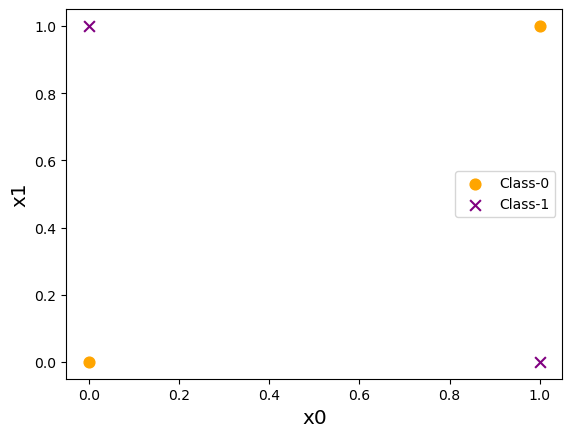

In [335]:
plot_data(x0, x1, y)

In [343]:
root = build_tree(dataset)
printTree(root)
print('Training error: ', error(root, dataset))

 Root: Leaf 1
Training error:  0.5


In [344]:
root_forced = build_tree(dataset, forced=True)
printTree(root_forced)
print('Training error: ', error(root_forced, dataset))

 Root: x1 >= 1
	 L: x0 >= 1
		 L: Leaf 0
		 R: Leaf 1
	 R: x0 >= 1
		 L: Leaf 1
		 R: Leaf 0
Training error:  0.0


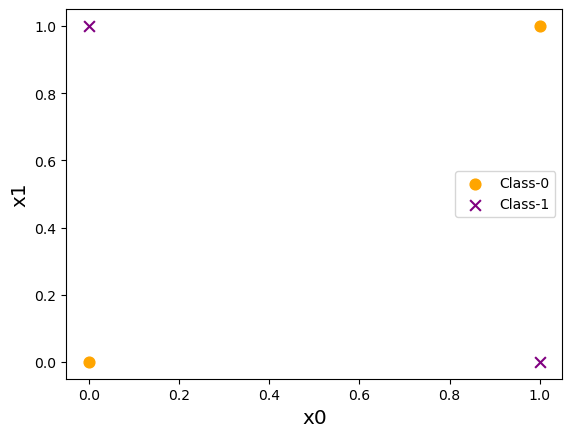

In [345]:
plot_data(x0, x1, y)

The dataset is the XOR dataset, where there are two features $x_0$ and $x_1$, and the label $y = x_0 \oplus x_1$.

All the splits have a $0$ gain ratio, and hence the root node becomes a leaf. 

If we force a split, the tree continues to grow until each node has samples of the same label. At this point, the training error will become $0$.

### Q3

In [347]:
x0, x1, y = get_data('Homework 2 data/Druns.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

In [348]:
root = build_tree(dataset, printLogs=True)

Feature candidate	Value Candidate		Gain ratio (or IG)
0 			 0.1 			 0.10051807676021828
0 			 0.0 			 0.0 (IG)
1 			 0.0 			 0.055953759631263686
1 			 1.0 			 0.00578004220515232
1 			 2.0 			 0.0011443495172767494
1 			 3.0 			 0.016411136842102134
1 			 4.0 			 0.04974906418177849
1 			 5.0 			 0.11124029586339795
1 			 6.0 			 0.23609960614360798
1 			 7.0 			 0.0559537596312636
1 			 8.0 			 0.4301569161309807
1 			 -1.0 			 0.10051807676021828
1 			 -2.0 			 0.0 (IG)


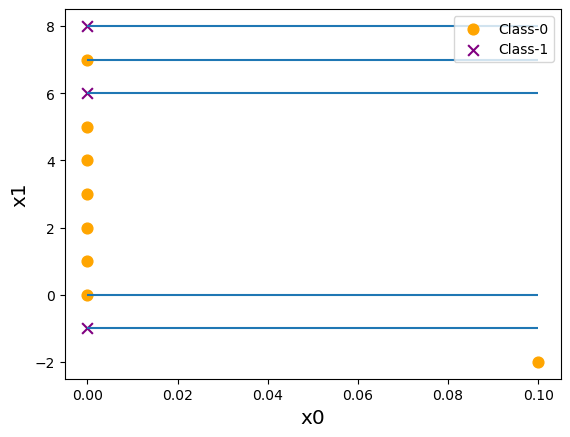

In [317]:
plot_data(x0, x1, y, root)

### Q4

In [349]:
x0, x1, y = get_data('Homework 2 data/D3leaves.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

In [352]:
root = build_tree(dataset)
printTree(root)

 Root: x1 >= 2.0
	 L: Leaf 1
	 R: x0 >= 10.0
		 L: Leaf 1
		 R: Leaf 0


*Logic rules*
- If feature 1  >= 2 or feature 0 >= 10, then the data has label 1
- If feature 1 < 2 and feature 0 < 10, then the data has label 0

### Q5

In [354]:
x0, x1, y = get_data('Homework 2 data/D1.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

In [355]:
root = build_tree(dataset)
printTree(root)

 Root: x1 >= 0.201829
	 L: Leaf 1
	 R: Leaf 0


The boundary will be horizontal line at 0.201829. If the point lies above this line, it has label 1, if it lies below, it has label 0.

In [356]:
x0, x1, y = get_data('Homework 2 data/D2.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

In [357]:
root = build_tree(dataset)
printTree(root)

 Root: x0 >= 0.533076
	 L: x1 >= 0.228007
		 L: x1 >= 0.424906
			 L: Leaf 1
			 R: x0 >= 0.708127
				 L: Leaf 1
				 R: x1 >= 0.32625
					 L: x0 >= 0.595471
						 L: x0 >= 0.646007
							 L: Leaf 1
							 R: x1 >= 0.403494
								 L: Leaf 1
								 R: Leaf 0
						 R: Leaf 0
					 R: Leaf 0
		 R: x0 >= 0.887224
			 L: x1 >= 0.037708
				 L: x1 >= 0.082895
					 L: Leaf 1
					 R: x0 >= 0.960783
						 L: Leaf 1
						 R: Leaf 0
				 R: Leaf 0
			 R: x0 >= 0.850316
				 L: x1 >= 0.169053
					 L: Leaf 1
					 R: Leaf 0
				 R: Leaf 0
	 R: x1 >= 0.88635
		 L: x0 >= 0.041245
			 L: x0 >= 0.104043
				 L: Leaf 1
				 R: x1 >= 0.964767
					 L: Leaf 1
					 R: Leaf 0
			 R: Leaf 0
		 R: x1 >= 0.691474
			 L: x0 >= 0.254049
				 L: Leaf 1
				 R: x0 >= 0.191915
					 L: x1 >= 0.792752
						 L: Leaf 1
						 R: Leaf 0
					 R: x1 >= 0.864128
						 L: x1 >= 0.865999
							 L: Leaf 0
							 R: Leaf 1
						 R: Leaf 0
			 R: x1 >= 0.534979
				 L: x0 >= 0.426073
					 L: Leaf 1
					

This is a very deep tree with multiple complex splits. this, it is not easy to understand the boundaries without visualizing them

### Q6

In [358]:
x0, x1, y = get_data('Homework 2 data/D1.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

In [359]:
root = build_tree(dataset)
printTree(root)

 Root: x1 >= 0.201829
	 L: Leaf 1
	 R: Leaf 0


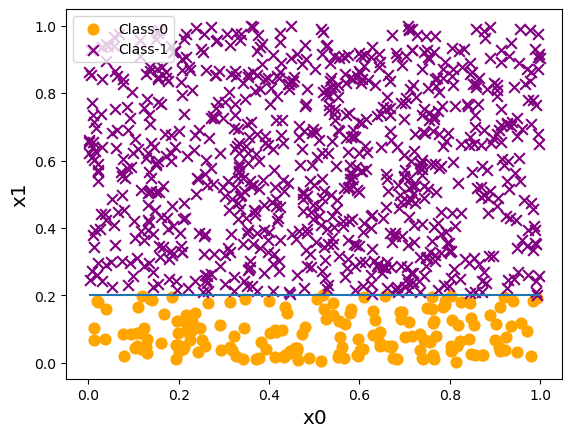

In [360]:
plot_data(x0, x1, y, root)

In [361]:
x0, x1, y = get_data('Homework 2 data/D2.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

In [362]:
root = build_tree(dataset)
printTree(root)

 Root: x0 >= 0.533076
	 L: x1 >= 0.228007
		 L: x1 >= 0.424906
			 L: Leaf 1
			 R: x0 >= 0.708127
				 L: Leaf 1
				 R: x1 >= 0.32625
					 L: x0 >= 0.595471
						 L: x0 >= 0.646007
							 L: Leaf 1
							 R: x1 >= 0.403494
								 L: Leaf 1
								 R: Leaf 0
						 R: Leaf 0
					 R: Leaf 0
		 R: x0 >= 0.887224
			 L: x1 >= 0.037708
				 L: x1 >= 0.082895
					 L: Leaf 1
					 R: x0 >= 0.960783
						 L: Leaf 1
						 R: Leaf 0
				 R: Leaf 0
			 R: x0 >= 0.850316
				 L: x1 >= 0.169053
					 L: Leaf 1
					 R: Leaf 0
				 R: Leaf 0
	 R: x1 >= 0.88635
		 L: x0 >= 0.041245
			 L: x0 >= 0.104043
				 L: Leaf 1
				 R: x1 >= 0.964767
					 L: Leaf 1
					 R: Leaf 0
			 R: Leaf 0
		 R: x1 >= 0.691474
			 L: x0 >= 0.254049
				 L: Leaf 1
				 R: x0 >= 0.191915
					 L: x1 >= 0.792752
						 L: Leaf 1
						 R: Leaf 0
					 R: x1 >= 0.864128
						 L: x1 >= 0.865999
							 L: Leaf 0
							 R: Leaf 1
						 R: Leaf 0
			 R: x1 >= 0.534979
				 L: x0 >= 0.426073
					 L: Leaf 1
					

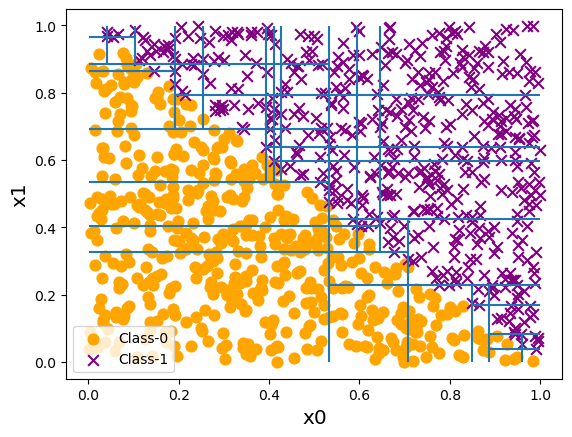

In [363]:
plot_data(x0, x1, y, root)

Decision trees make only horizontal and vertical boundaries in every split - they do not linearly combine the features in any step. Thus although both data is linearly separable, the decision tree algorithm will require more number of splits, and hence a higher depth tree to classify D2 as compared to D1.

### Q7

In [247]:
x0, x1, y = get_data('Homework 2 data/Dbig.txt')
dataset = np.array(list(zip(x0, x1, y)))
plotter = []

rng = np.random.default_rng()
dataset_perm = dataset.copy()
rng.shuffle(dataset_perm)

D32_train = dataset_perm[:32]
D128_train = dataset_perm[:128]
D512_train = dataset_perm[:512]
D2048_train = dataset_perm[:2048]
D8192_train = dataset_perm[:8192]

D32_test = dataset_perm[32:]
D128_test = dataset_perm[128:]
D512_test = dataset_perm[512:]
D2048_test = dataset_perm[2048:]
D8192_test = dataset_perm[8192:]

0.11065409309791333


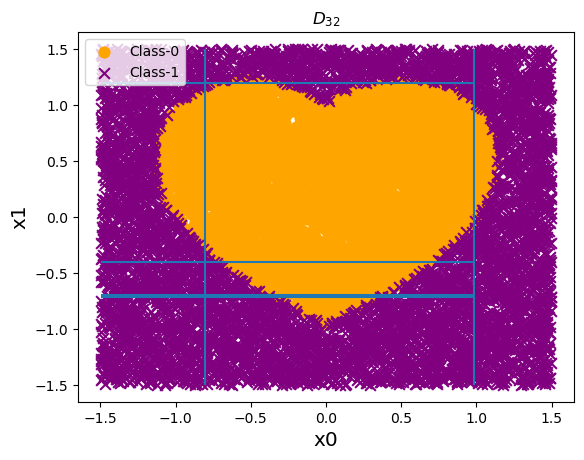

In [286]:
root_32 = build_tree(D32_train)
err_32 = error(root_32, D32_test)
print(err_32)
plot_data(x0, x1, y, root_32, '$D_{32}$')

0.09754862236628849


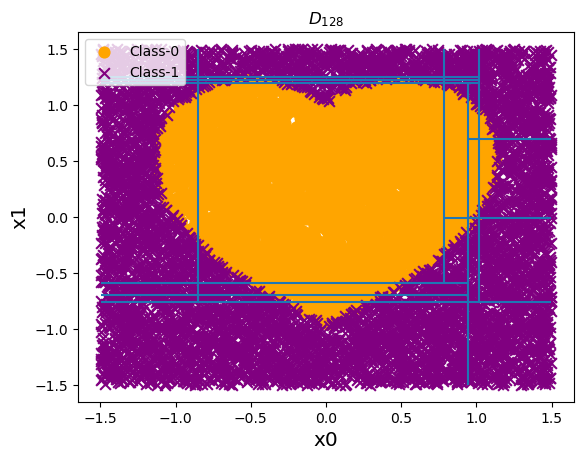

In [287]:
root_128 = build_tree(D128_train)
err_128 = error(root_128, D128_test)
print(err_128)
plot_data(x0, x1, y, root_128, '$D_{128}$')

0.0755691399662732


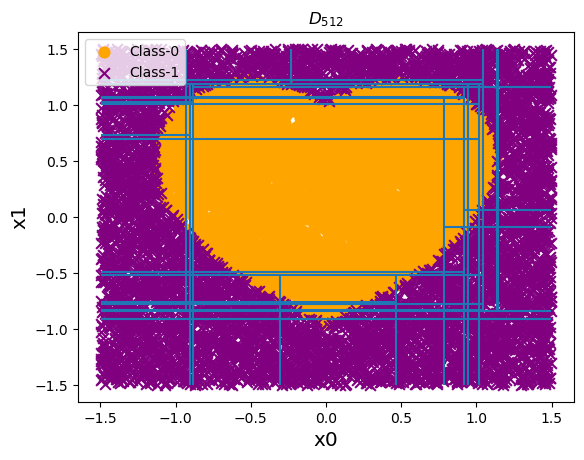

In [288]:
root_512 = build_tree(D512_train)
err_512 = error(root_512, D512_test)
print(err_512)
plot_data(x0, x1, y, root_512, '$D_{512}$')

0.029049295774647887


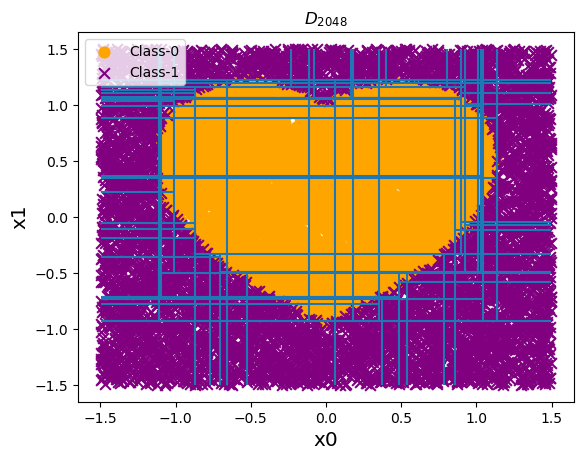

In [289]:
root_2048 = build_tree(D2048_train)
err_2048 = error(root_2048, D2048_test)
print(err_2048)
plot_data(x0, x1, y, root_2048, '$D_{2048}$')

0.01991150442477876


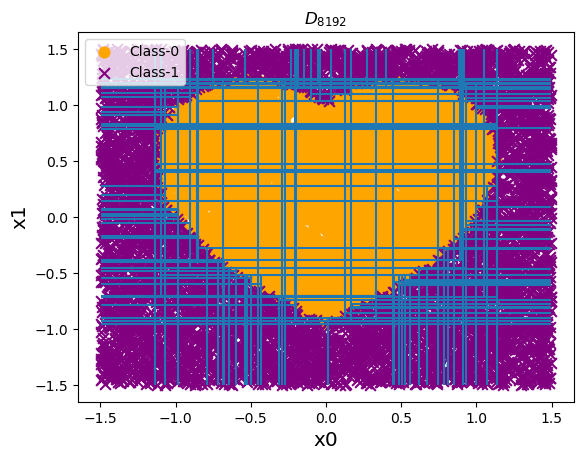

In [291]:
root_8192 = build_tree(D8192_train)
err_8192 = error(root_8192, D8192_test)
print(err_8192)
plot_data(x0, x1, y, root_8192, '$D_{8192}$')

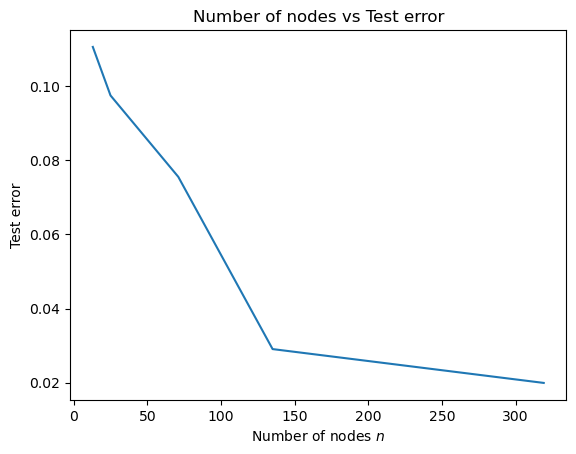

In [292]:
nodes_32 = count_nodes(root_32)
nodes_128 = count_nodes(root_128)
nodes_512 = count_nodes(root_512)
nodes_2048 = count_nodes(root_2048)
nodes_8192 = count_nodes(root_8192)
plt.plot([nodes_32, nodes_128, nodes_512, nodes_2048, nodes_8192], [err_32, err_128, err_512, err_2048, err_8192])
plt.xlabel('Number of nodes $n$')
plt.ylabel('Test error')
plt.title('Number of nodes vs Test error')
plt.savefig('hw2_q7_err.pdf')

## Part 3

In [364]:
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay

In [367]:
features = list(zip())
clf = tree.DecisionTreeClassifier()
clf = clf.fit(D32_train[:,:2], D32_train[:,2])

In [372]:
err_32 = 1-clf.score(D32_test[:,:2], D32_test[:,2])
print(err_32)

0.1622191011235955


In [374]:
nodes_32 = clf.tree_.node_count
print(nodes_32)

17
